In [1]:
import torch
import random
import numpy as np
from torch.nn.init import normal_
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from skimage.io import imread
from tqdm.notebook import tqdm
import os
plt.style.use('ggplot')


from torch.nn import Linear, Conv2d, ConvTranspose2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
input_height = 512
input_width = input_height

in_channels = 3
unit_conv = 64
out_channels = 1
kernel_size = 3
padding = 1
stride = 1

In [4]:
class Net(nn.Module):
    def __init__(self,
                 input_height,
                 input_width,
                 in_channels,
                 unit_conv,
                 kernel_size,
                 out_channels,
                 padding):
        super(Net, self).__init__()

        # channles/filters in, out
        # 3, 64
        self.conv_down_1 = Conv2d(in_channels=in_channels,
                                  out_channels=unit_conv,
                                  kernel_size=kernel_size,
                                  stride=stride,
                                  padding=padding)
        # 64, 64
        self.conv_down_2 = Conv2d(in_channels=unit_conv,
                                  out_channels=unit_conv,
                                  kernel_size=kernel_size,
                                  stride=stride,
                                  padding=padding)

        # 64, 128
        self.conv_down_3 = Conv2d(in_channels=unit_conv, out_channels=unit_conv * 2, kernel_size=kernel_size, stride=stride, padding=padding)
        # 64, 128
        self.conv_down_4 = Conv2d(in_channels=unit_conv * 2, out_channels=unit_conv * 2, kernel_size=kernel_size, stride=stride, padding=padding)
        # maxpool
        # 128, 256
        self.conv_down_5 = Conv2d(in_channels=unit_conv * 2, out_channels=unit_conv * 4, kernel_size=kernel_size, stride=stride, padding=padding)
        # 256, 256
        self.conv_down_6 = Conv2d(in_channels=unit_conv * 4, out_channels=unit_conv * 4, kernel_size=kernel_size, stride=stride, padding=padding)
        # maxpool
        # 256, 512
        self.conv_down_7 = Conv2d(in_channels=unit_conv * 4, out_channels=unit_conv * 8, kernel_size=kernel_size, stride=stride, padding=padding)
        # 512, 512
        self.conv_down_8 = Conv2d(in_channels=unit_conv * 8, out_channels=unit_conv * 8, kernel_size=kernel_size, stride=stride, padding=padding)
        # maxpool
        # 512, 1024
        self.conv_down_9 = Conv2d(in_channels=unit_conv * 8, out_channels=unit_conv * 16, kernel_size=kernel_size, stride=stride, padding=padding)
        # 1024, 1024
        self.conv_down_10 = Conv2d(in_channels=unit_conv * 16, out_channels=unit_conv * 16, kernel_size=kernel_size, stride=stride, padding=padding)

        # Reverse from here:

        # introducing the upconvolution aka transpose convolution
        # tranpose_conv_parameters
        # ConvTranspose2d(in_channels = 1, out_channels = 1, kernel_size = 4, stride = 2, padding = 1)
        kernal_size_tp = 2
        stride_tp = 2
        paddig_tp = 0

        # transpose-conv
        # 1024, 512
        self.conv_tp_11 = ConvTranspose2d(in_channels=unit_conv * 16,
                                          out_channels=unit_conv * 8,
                                          kernel_size=kernal_size_tp,
                                          stride=stride_tp,
                                          padding=paddig_tp)

        # copy back up to 1024 channeles
        # 1024, 512
        self.conv_up_12 = Conv2d(in_channels=unit_conv * 16, out_channels=unit_conv * 8, kernel_size=kernel_size, stride=stride, padding=padding)
        # 512, 512
        self.conv_up_13 = Conv2d(in_channels=unit_conv * 8, out_channels=unit_conv * 8, kernel_size=kernel_size, stride=stride, padding=padding)

        # transpose-conv
        # 512, 256
        self.conv_tp_14 = ConvTranspose2d(in_channels=unit_conv * 8, out_channels=unit_conv * 4, kernel_size=kernal_size_tp, stride=stride_tp, padding=paddig_tp)
        # copy back up to 512 channeles
        # 512, 256
        self.conv_up_15 = Conv2d(in_channels=unit_conv * 8, out_channels=unit_conv * 4, kernel_size=kernel_size, stride=stride, padding=padding)
        # 256, 256
        self.conv_up_16 = Conv2d(in_channels=unit_conv * 4, out_channels=unit_conv * 4, kernel_size=kernel_size, stride=stride, padding=padding)

        # transpose-conv
        # 256, 128
        self.conv_tp_17 = ConvTranspose2d(in_channels=unit_conv * 4, out_channels=unit_conv * 2, kernel_size=kernal_size_tp, stride=stride_tp, padding=paddig_tp)
        # copy back up to 256 channels
        # 256, 128
        self.conv_up_18 = Conv2d(in_channels=unit_conv * 4, out_channels=unit_conv * 2, kernel_size=kernel_size, stride=stride, padding=padding)
        # 128, 128
        self.conv_up_19 = Conv2d(in_channels=unit_conv * 2, out_channels=unit_conv * 2, kernel_size=kernel_size, stride=stride, padding=padding)

        # transpose-conv
        # 128, 64
        self.conv_tp_20 = ConvTranspose2d(in_channels=unit_conv * 2, out_channels=unit_conv, kernel_size=kernal_size_tp, stride=stride_tp, padding=paddig_tp)

        # copy back up to 128 channels
        # 128, 64
        self.conv_up_21 = Conv2d(in_channels=unit_conv * 2, out_channels=unit_conv, kernel_size=kernel_size, stride=stride, padding=padding)
        # 64, 64
        self.conv_up_22 = Conv2d(in_channels=unit_conv, out_channels=unit_conv, kernel_size=kernel_size, stride=stride, padding=padding)

        # outlayer
        # 64, 1
        self.conv_final_23 = Conv2d(in_channels=unit_conv, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

        # init the weights according to how it is explained in the paper
        normal_(self.conv_down_1.weight, 0, np.sqrt(2/(9*in_channels)))
        normal_(self.conv_down_2.weight, 0, np.sqrt(2/(9*unit_conv)))
        normal_(self.conv_down_3.weight, 0, np.sqrt(2/(9*unit_conv)))
        normal_(self.conv_down_4.weight, 0, np.sqrt(2/(9*unit_conv*2)))
        normal_(self.conv_down_5.weight, 0, np.sqrt(2/(9*unit_conv*2)))
        normal_(self.conv_down_6.weight, 0, np.sqrt(2/(9*unit_conv*4)))
        normal_(self.conv_down_7.weight, 0, np.sqrt(2/(9*unit_conv*4)))
        normal_(self.conv_down_8.weight, 0, np.sqrt(2/(9*unit_conv*8)))
        normal_(self.conv_down_9.weight, 0, np.sqrt(2/(9*unit_conv*8)))
        normal_(self.conv_down_10.weight, 0, np.sqrt(2/(9*unit_conv*16)))

        normal_(self.conv_tp_11.weight, 0, np.sqrt(2/(9*unit_conv*16)))
        normal_(self.conv_up_12.weight, 0, np.sqrt(2/(9*unit_conv*16)))
        normal_(self.conv_up_13.weight, 0, np.sqrt(2/(9*unit_conv*8)))

        normal_(self.conv_tp_14.weight, 0, np.sqrt(2/(9*unit_conv*8)))
        normal_(self.conv_up_15.weight, 0, np.sqrt(2/(9*unit_conv*8)))
        normal_(self.conv_up_16.weight, 0, np.sqrt(2/(9*unit_conv*4)))

        normal_(self.conv_tp_17.weight, 0, np.sqrt(2/(9*unit_conv*4)))
        normal_(self.conv_up_18.weight, 0, np.sqrt(2/(9*unit_conv*4)))
        normal_(self.conv_up_19.weight, 0, np.sqrt(2/(9*unit_conv*2)))

        normal_(self.conv_tp_20.weight, 0, np.sqrt(2/(9*unit_conv*2)))
        normal_(self.conv_up_21.weight, 0, np.sqrt(2/(9*unit_conv*2)))
        normal_(self.conv_up_22.weight, 0, np.sqrt(2/(9*unit_conv)))

        normal_(self.conv_final_23.weight, 0, np.sqrt(2/(9*unit_conv)))


    def forward(self, x):  # x.size() = [batch, channel, height, width]

        x1 = relu(self.conv_down_1(x))
        x2 = relu(self.conv_down_2(x1))
        x2mp = F.max_pool2d(x2, 2)

        x3 = relu(self.conv_down_3(x2mp))
        x4 = relu(self.conv_down_4(x3))
        x4mp = F.max_pool2d(x4, 2)

        x5 = relu(self.conv_down_5(x4mp))
        x6 = relu(self.conv_down_6(x5))
        x6mp = F.max_pool2d(x6, 2)

        x7 = relu(self.conv_down_7(x6mp))
        x8 = relu(self.conv_down_8(x7))
        x8mp = F.max_pool2d(x8, 2)

        x9 = relu(self.conv_down_9(x8mp))
        x10 = relu(self.conv_down_10(x9))

        # tranpose conv
        x11 = self.conv_tp_11(x10)
        x11c = torch.cat((x8, x11), 1)

        x12 = relu(self.conv_up_12(x11c))
        x13 = relu(self.conv_up_13(x12))

        x14 = self.conv_tp_14(x13)
        x14c = torch.cat((x6, x14), 1)

        x15 = relu(self.conv_up_15(x14c))
        x16 = relu(self.conv_up_16(x15))

        x17 = self.conv_tp_17(x16)
        x17c = torch.cat((x4, x17), 1)

        x18 = relu(self.conv_up_18(x17c))
        x19 = relu(self.conv_up_19(x18))

        x20 = self.conv_tp_20(x19)
        x20c = torch.cat((x2, x20), 1)

        x21 = relu(self.conv_up_21(x20c))
        x22 = relu(self.conv_up_22(x21))

        x23 = torch.sigmoid(self.conv_final_23(x22))
        return x23

In [5]:
# initiate and print the network
#try with a forward parse in a dummy tensor
channels = 3
w,h = 512, 512
x = np.random.normal(0,1, (1, channels, w, h)).astype('float32')
x = Variable(torch.from_numpy(x)).cuda()

unet = Net(input_height, input_width, in_channels, unit_conv, kernel_size, out_channels, padding)
unet.cuda()
out = unet(x)
print(out.size())



torch.Size([1, 1, 512, 512])


# Dataloader:

#### Calculate means:

In [6]:
#shitty helper function that is needed so we cant sample train1 to train9
#but only train10 to train_max (what ever the max train is)
#as this will make the code after inconsistent.
def sampler_data(IDs_val,split):
  def equal_lengths(l):
    length_of_first_ele = len(l[0])
    for ele in l:
      if len(ele) != length_of_first_ele:
        return False
    return True

  while True:
    l = random.sample(IDs_val,int(len(IDs_val)/split))
    if equal_lengths(l):
      break

  return l
    
  
train_dir = 'drive/My Drive/Warwick_dataset_aug/'
test_dir = 'drive/My Drive/Warwick_dataset_multi_zero/'
#test_dir = 'drive/My Drive/Warwick_dataset_aug/'

files_train = os.listdir(train_dir)
IDs_train = [file for file in files_train if not file.startswith("testB") and not file.startswith("testA")]

files_test_val = os.listdir(test_dir)
IDs_test = [file for file in files_test_val if file.startswith("testB")]
IDs_test2 = [file for file in files_test_val if file.startswith("testA")]
IDs_val = [file for file in files_test_val if not file.startswith("testB") and not file.startswith("testA")]

#make for instance "train_x_.bmp" and "train_x_anno_bmp" into "train_x"
IDs_train = [ID[:-9] for ID in IDs_train if ID.endswith("_anno.bmp")]
IDs_val = [ID[:-9] for ID in IDs_val if ID.endswith("_anno.bmp")]
IDs_test = [ID[:-9] for ID in IDs_test if ID.endswith("_anno.bmp")]
IDs_test2 = [ID[:-9] for ID in IDs_test2 if ID.endswith("_anno.bmp")]


IDs_val = sampler_data(IDs_val,10)
#remove val ids from train ids:
for id_val in IDs_val:
  print(id_val)
  IDs_train = [id for id in IDs_train if not id.startswith(id_val)]

#create full paths
IDs_train = sorted([os.path.join(train_dir, ID) for ID in IDs_train])
IDs_val = sorted([os.path.join(test_dir, ID) for ID in IDs_val])
IDs_test = sorted([os.path.join(test_dir, ID) for ID in IDs_test])
IDs_test2 = sorted([os.path.join(test_dir, ID) for ID in IDs_test2])


print(len(IDs_train))
print(len(IDs_val))
print(len(IDs_test))
print(len(IDs_test2))



def means_and_stds(IDs, dir):
  meansR,meansG,meansB = [],[],[]
  stdsR,stdsG,stdsB = [],[],[]
  for ID in IDs:
    im = imread(ID+".bmp")
    meansR.append(np.mean(im[:,:,0]))
    meansG.append(np.mean(im[:,:,1]))
    meansB.append(np.mean(im[:,:,2]))
    stdsR.append(np.std(im[:,:,0]))
    stdsG.append(np.std(im[:,:,1]))
    stdsB.append(np.std(im[:,:,2]))


  meanR = np.mean(meansR)
  meanG = np.mean(meansG)
  meanB = np.mean(meansB)

  stdR = np.mean(stdsR)
  stdG = np.mean(stdsG)
  stdB = np.mean(stdsB)

  means = [meanR, meanG, meanB]
  stds = [stdR, stdG, stdB]
  return means, stds

means_train, stds_train = means_and_stds(IDs_train, train_dir)
means_val, stds_val = means_and_stds(IDs_val, train_dir)
means_test,  stds_test = means_and_stds(IDs_test, test_dir)
means_test2,  stds_test2 = means_and_stds(IDs_test2, test_dir)


print(means_train, stds_train)
print(means_val, stds_val)
print(means_test,  stds_test)
print(means_test2,  stds_test2)

train_33
train_44
train_78
train_36
train_31
train_32
train_25
train_64
462
8
20
60
[99.0051249384364, 64.56200715267298, 98.78262031852425] [99.3024445109881, 73.69468423810844, 97.2820163425061]
[130.6620397567749, 82.39078855514526, 130.41958045959473] [100.26237056863442, 73.3309882397203, 97.90838856527733]
[139.6540952682495, 94.24285430908203, 138.2876214981079] [101.89631986336035, 81.70258314550047, 99.09259072764283]
[126.72630233764649, 83.31185143788656, 126.59277617136637] [98.86681294701312, 75.03164144618366, 96.66894510142541]


In [7]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, ID, means, stds):
        'Initialization'
        self.IDs = ID
        self.means = means
        self.stds = stds

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.IDs[index]
        # Load data and get label
        X_np = imread(ID+ '.bmp')
        y_np = imread(ID+ '_anno.bmp',as_gray=True)

        X_np_norm = X_np.copy()
        a = (X_np[:,:,0] - self.means[0])/self.stds[0]
        b = (X_np[:,:,1] - self.means[1])/self.stds[1]
        c = (X_np[:,:,2] - self.means[2])/self.stds[2]
        d = np.stack((a,b,c))

        y_np[y_np>0]=1      # can be removed later

        X = torch.from_numpy(d.astype('float32'))
        y = torch.from_numpy(y_np)

        return X, y, index
training_set = Dataset(IDs_train, means_train, stds_train)
test_set = Dataset(IDs_test, means_test,  stds_test)
params = {'batch_size': 1,
          'shuffle': True}
training_generator = torch.utils.data.DataLoader(training_set, **params)
test_generator = torch.utils.data.DataLoader(test_set, **params)

In [8]:
from skimage.measure import label
!pip install imgaug==0.2.5
!pip install scikit-image==0.18.0rc0
from skimage.metrics import hausdorff_distance
import numpy as np


class BinaryImageMetrics():
    def __init__(self, y_true, y_pred):
        #TODO: Add documentation
        #TODO: implement Adjusted Rand Index and https://web.stanford.edu/class/cs273/scribing/2004/class8/scribe8.pdf
        
        # Numpy have the bug : ValueError: cannot set WRITEABLE flag to True of this array
        # That is why we copy the array

        # We force the predictions to be binary

        y_true = np.copy(y_true)
        y_pred = np.copy(y_pred)
        y_true[y_true>0]=1
        y_pred[y_pred>0] = 1
        self.y_true= y_true
        self.y_pred = y_pred
        self.y_true_label = label(self.y_true)
        self.y_pred_label = label(self.y_pred)

    def get_count(self):
        count_y_true = np.max(self.y_true_label)
        count_y_pred = np.max(self.y_pred_label)
        if count_y_pred == 0 or count_y_true == 0:
            return 0.0
        else:
            return min(count_y_true/count_y_pred, count_y_pred/count_y_true)

    def get_f1(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self.confusion_matrix(y_true, y_pred)
        f1 = 2*tp / (2*tp +fp + fn)
        return f1
        
    def get_iou(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self.confusion_matrix(y_true, y_pred)
        f1 = tp / (tp +fp + fn)
        return f1

    def get_hausdroff_dist(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
        
        if y_true.max() == 0 or y_pred.max() == 0:
            haus_dist = np.sqrt(y_true.shape[0]*y_true.shape[1])
        else:
            haus_dist = hausdorff_distance(y_true, y_pred)
        return haus_dist

    def get_iou_obj(self):
        iou_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(),minlength=2)[1],1)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            iou = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_iou(y_true=gi, y_pred=si)
            iou_obj += iou

        for idx in range(1, self.y_pred_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            iou = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_iou(y_true=gi, y_pred=si)
            iou_obj += iou

        iou_obj /= 2

        return iou_obj


    def get_f1_obj(self):
        f1_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(),minlength=2)[1],1)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            f1 = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_f1(y_true=gi, y_pred=si)
            f1_obj += f1

        for idx in range(1, self.y_pred_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            f1 = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_f1(y_true=gi, y_pred=si)
            f1_obj += f1

        f1_obj /= 2

        return f1_obj


    def get_hausdorff_obj_distance(self):
        haus_dist_obj = 0
        total_y_pred = np.bincount(self.y_pred.flatten(), minlength=2)[1]
        total_y_true = np.bincount(self.y_true.flatten(), minlength=2)[1]
        
        if total_y_true == 0 or total_y_pred == 0:
            # Note this conversion is different from
            # https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/evaluation/
            # But the Hausdorff distance is not defined for non-overlapping objects.
            # Note that the distance of sqrt(h^2+w^2) is an arbary choice.
            # 0.0 would skew the distance to much to the positive side, and
            # infinite is misleading. 
            # In case both objects are empty, we return the max dist of y_true
            return np.sqrt(self.y_true.shape[0]**2+self.y_true.shape[1]**2)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=False)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((gi.shape[0]*gi.shape[1])/total_y_true)*np.sqrt(gi.shape[0]**2+gi.shape[1]**2)
            else:
                haus_dist = (np.bincount(gi.flatten())[1]/total_y_true)*self.get_hausdroff_dist(y_true=gi, y_pred=si)
            haus_dist_obj += haus_dist

        for idx in range(1, self.y_pred_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=True)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((si.shape[0]*si.shape[1])/total_y_pred)*np.sqrt(si.shape[0]**2+si.shape[1]**2)
            else:
                haus_dist = (np.bincount(si.flatten())[1]/total_y_pred)*self.get_hausdroff_dist(y_true=gi, y_pred=si)
            haus_dist_obj += haus_dist

        haus_dist_obj /= 2
        return haus_dist_obj

    def confusion_matrix(self, y_true, y_pred):
        y_true= y_true.flatten()
        y_pred = y_pred.flatten()*2
        cm = y_true+y_pred
        cm = np.bincount(cm, minlength=4)
        tn, fp, fn, tp = cm
        return tp, fp, tn, fn
    
    def _get_overlap(self, idx, return_rectangle=False, y_true_p_switch=False):
        if y_true_p_switch:
            y_pred = self.y_true_label
            y_true = self.y_pred_label
        else:
            y_true = self.y_true_label
            y_pred = self.y_pred_label

        roi_y_true = np.argwhere(y_true == idx)
        roi_y_pred = y_pred[roi_y_true[:,0],roi_y_true[:,1]]

        # Finds max overlap, excluding background
        matching_idx = np.bincount(roi_y_pred)
        if len(matching_idx)<=1:
            matching_idx = -1
        else:
            matching_idx = matching_idx[1:].argmax()+1
        if return_rectangle:
            bbox, _, _ = self._bounding_box(roi_y_true, at_origon=False)
            roi_y_true = y_true[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]
            roi_y_pred = y_pred[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]
            roi_y_true =(roi_y_true==idx)*1

        else:
            roi_y_true = np.ones((len(roi_y_true)),dtype=int)
        roi_y_pred = (roi_y_pred==matching_idx)*1
        
        return roi_y_true, roi_y_pred
        
    def _bounding_box(self, points, at_origon=False):
        bbox = [min(points[:,0]), min(points[:,1]), max(points[:,0]), max(points[:,1])]
        min_x = bbox[0]
        min_y = bbox[1]
        if at_origon:
            bbox = [bbox[0] - min_x,
                    bbox[1] - min_y,
                    bbox[2] - min_x,
                    bbox[3] - min_y]
        return bbox, min_x, min_y
        







#### Get loss acc and plots of Unet predictions


TestB:  [0.22012612243231974, 0.545610529821056, 0.942231912168633, 0.8740248116459567, 57.53197221693892]
TestA:  [0.2043303851732763, 0.5463551933778282, 0.8784772766749972, 0.7748577689023532, 42.69964196991568]


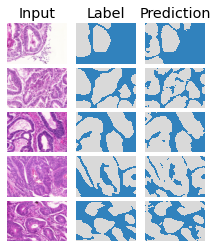

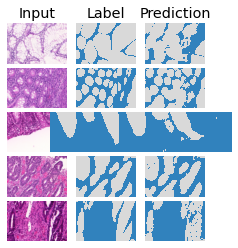

In [9]:
from google.colab import files

plt.style.use('ggplot')
#function to unpad a 0-padded image 
def unpad(image1, image2=None):
    def single_unpad(image):
        length, width = image.shape
        for i in range(length):
            if np.mean(image[i, :]) != 0:
                upper = i
                break

        for i in reversed(range(length)):
            if np.mean(image[i, :]) != 0:
                lower = i + 1
                break
        return upper, lower

    if image2 is None:
        upper, lower = single_unpad(image1)
        return image1[upper:lower, :]

    else:
        upper_image1, lower_image1 = single_unpad(image1)
        upper_image2, lower_image2 = single_unpad(image2)
        upper = min(upper_image1, upper_image2)
        lower = max(lower_image1, lower_image2)
        return image1[upper:lower, :], image2[upper:lower, :]



path = 'drive/My Drive/'
model_name ="unet_pretty_good.pt"
#model_name ="unet_long1.pt"

full_path = os.path.join(path, model_name)
criterion = nn.BCELoss()

test_set = Dataset(IDs_test, means_test,  stds_test)
test_set2 = Dataset(IDs_test2, means_test2,  stds_test2)
test_params = {'batch_size': 1, 'shuffle': False}
test_generator = torch.utils.data.DataLoader(test_set, **test_params)
test_generator2 = torch.utils.data.DataLoader(test_set2, **test_params)

#unet = Net(input_height, input_width, in_channels, unit_conv, kernel_size, out_channels, padding)
unet = Net(input_height, input_width, in_channels, 16, kernel_size, out_channels, padding)
unet.load_state_dict(torch.load(full_path))
unet.cuda()
unet.eval()

def get_loss_and_acc(data_loader, unet, criterion, IDs_test, 
                     unpad_ = False, plot_ = 0, only_loss = False):
  
  #               loss    count      f1         f1_obj     hausdorff
  loss_and_acc = [0,      0,         0,         0,         0]
  fig, ax = plt.subplots(plot_, 3)
  plt.subplots_adjust(wspace=-0.65, hspace=0.1)

  for c, data in enumerate(data_loader,0):
    inputs, label, idx = data
    inputs_copy = np.copy(inputs).squeeze()

    inputs = Variable(inputs).cuda()
    label = Variable(label).type(torch.float32).cuda()
    output = unet(inputs)
    loss_and_acc[0] += criterion(output.squeeze(), label.squeeze()).detach().item()
    
    #determine to calculated test acc and plots and aswell
    if not only_loss:
      output = output.cpu().detach().squeeze().numpy()
      label = label.cpu().detach().squeeze().numpy()

      label[label > 0.5] = 1
      label[label <= 0.5] = 0
      label = label.astype('int64')
      output[output > 0.5] = 1
      output[output <= 0.5] = 0
      output = output.astype('int64')


      if plot_ > c:
        im = imread(IDs_test[c]+".bmp")
        im = np.asarray(im)


        label, output = unpad(label, output)
        dim0 = unpad(im[:,:,0])
        dim1 = unpad(im[:,:,1])
        dim2 = unpad(im[:,:,2])
        im = np.stack((dim0,dim1,dim2), axis=2)

        ax[c,0].imshow(im)
        ax[c,0].axis('off')

        ax[c,1].imshow(label,interpolation="nearest",cmap = "tab20c")
        ax[c,1].axis('off')
    
        ax[c,2].imshow(output,interpolation="nearest", cmap = "tab20c")
        ax[c,2].axis('off')
      
        if c == 0:
          ax[c,0].set_title("Input")
          ax[c,1].set_title("Label")
          ax[c,2].set_title("Prediction")

        fig.show()


      
      metrics = BinaryImageMetrics(label, output)
      loss_and_acc[1] += metrics.get_count()
      loss_and_acc[2] += metrics.get_f1()
      loss_and_acc[3] += metrics.get_f1_obj()
      loss_and_acc[4] += metrics.get_hausdorff_obj_distance()
    
  #fig.savefig('unetoutput.png', dpi=300)
  #files.download("unetoutput.png") 
  loss_and_acc = [val/c for val in loss_and_acc]

  if only_loss:
    return loss_and_acc[0]
  else:
    return loss_and_acc


print("TestB: ", get_loss_and_acc(test_generator, unet, criterion, IDs_test = IDs_test, unpad_ = True, plot_ = 5))
print("TestA: ", get_loss_and_acc(test_generator2, unet, criterion, IDs_test = IDs_test2, unpad_ = True, plot_ = 5))


#### Get plot of mask rcnn segmentations

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

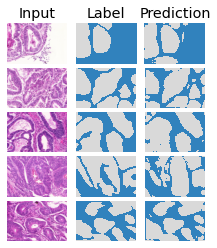

In [10]:
from PIL import Image
import matplotlib.image as image

IDs_test_eval = sorted([file[:-4] for file in files_test_val if file.startswith("testB") and not file.endswith("anno.bmp") ])

path_true = 'drive/My Drive/Warwick_dataset_multi_zero/'
path_proposed = 'drive/My Drive/Warwick_mrcnn_output2/'


fig, ax = plt.subplots(5, 3)
plt.subplots_adjust(wspace=-0.65, hspace=0.1)
c= 0
for c, file in enumerate(IDs_test_eval):
  
    true_file = os.path.join(path_true, file+ ".bmp")
    label = os.path.join(path_true, file+ "_anno.bmp")
    proposed_file = os.path.join(path_proposed, file+ ".bmp")


    true_img = np.asarray(Image.open(true_file))
    label = np.asarray(imread(label))
    propsoed_img = np.asarray(Image.open(proposed_file))

    label[label > 0.5] = 1
    label[label <= 0.5] = 0

    label, output = unpad(label, propsoed_img)
    dim0 = unpad(true_img[:,:,0])
    dim1 = unpad(true_img[:,:,1])
    dim2 = unpad(true_img[:,:,2])
    true_img = np.stack((dim0,dim1,dim2), axis=2)

    ax[c,0].imshow(true_img)
    ax[c,0].axis('off')
  
    #ax2.imshow(label,interpolation="nearest",cmap = "tab20c")
    ax[c,1].imshow(label,interpolation="nearest",cmap = "tab20c")
    ax[c,1].axis('off')


    ax[c,2].imshow(output,interpolation="nearest", cmap = "tab20c")
    ax[c,2].axis('off')
  

    if c == 0:
      ax[c,0].set_title("Input")
      ax[c,1].set_title("Label")
      ax[c,2].set_title("Prediction")
    
    if c == 4:
      break

fig.savefig('mrcnn_output.png', dpi=300)
files.download("mrcnn_output.png") 
fig.show()



# Training

A new training has started!

1. epoch



average epoch train loss was: 0.4527513316522042


<Figure size 432x288 with 0 Axes>

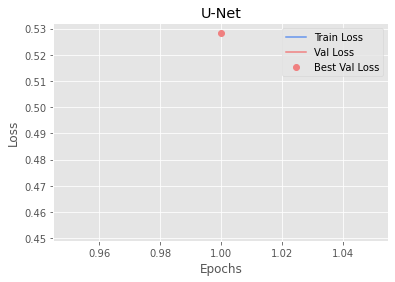


2. epoch



average epoch train loss was: 0.31436265259981155


<Figure size 432x288 with 0 Axes>

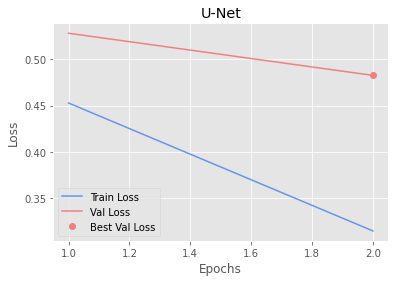


3. epoch



average epoch train loss was: 0.29639473526428145


<Figure size 432x288 with 0 Axes>

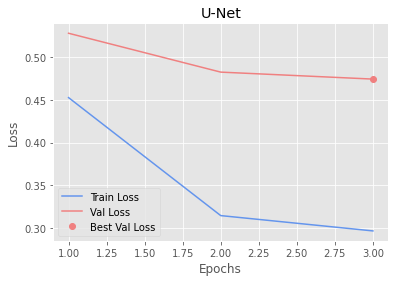


4. epoch



average epoch train loss was: 0.2852758305768172


<Figure size 432x288 with 0 Axes>

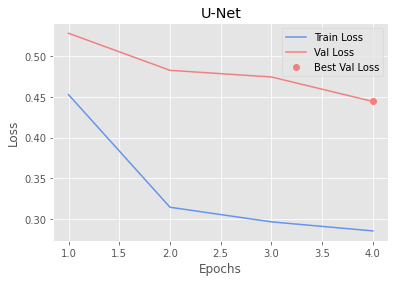


5. epoch



average epoch train loss was: 0.2728787465021014


<Figure size 432x288 with 0 Axes>

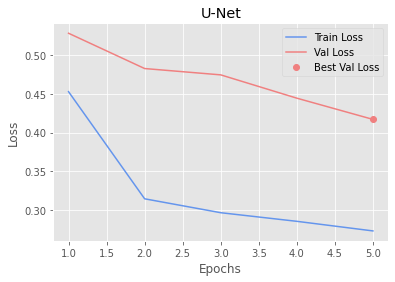


6. epoch



average epoch train loss was: 0.26458754142125446


<Figure size 432x288 with 0 Axes>

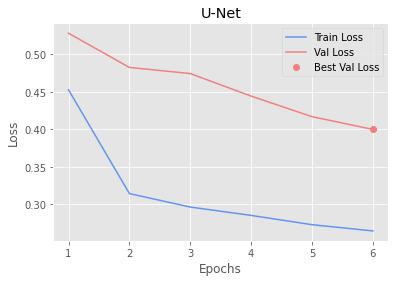


7. epoch



average epoch train loss was: 0.25990211497992277


<Figure size 432x288 with 0 Axes>

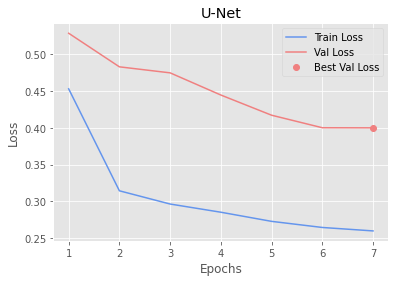


8. epoch



average epoch train loss was: 0.2417162088677287


<Figure size 432x288 with 0 Axes>

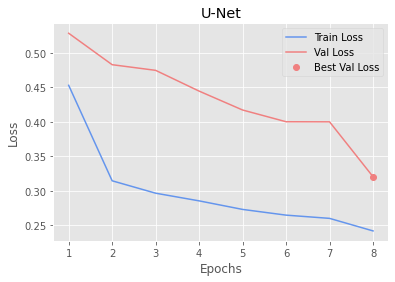


9. epoch



average epoch train loss was: 0.2244012594843904


<Figure size 432x288 with 0 Axes>

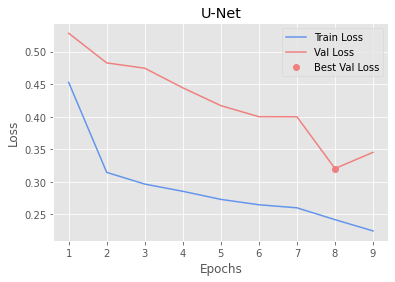


10. epoch



average epoch train loss was: 0.2051007367360095


<Figure size 432x288 with 0 Axes>

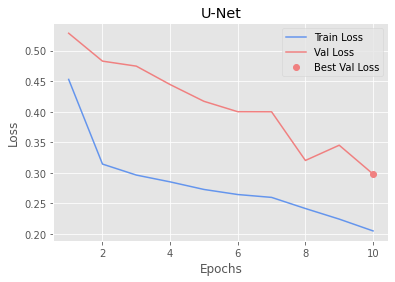


11. epoch



average epoch train loss was: 0.18170660578956208


<Figure size 432x288 with 0 Axes>

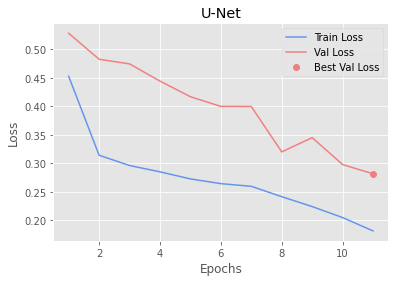


12. epoch



average epoch train loss was: 0.16708127145345011


<Figure size 432x288 with 0 Axes>

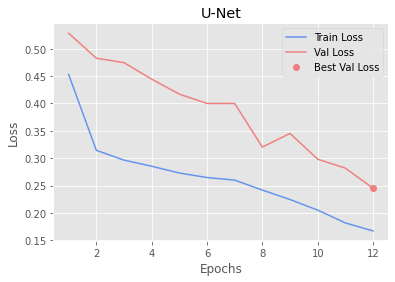

At epoch 12 a new best model was found and saved!

13. epoch



average epoch train loss was: 0.1544110329511265


<Figure size 432x288 with 0 Axes>

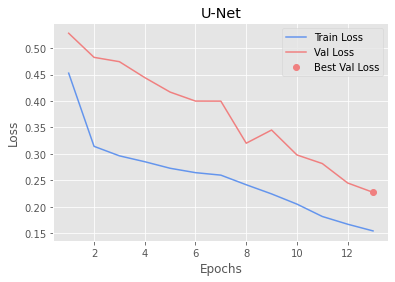

At epoch 13 a new best model was found and saved!

14. epoch



average epoch train loss was: 0.13631045212969184


<Figure size 432x288 with 0 Axes>

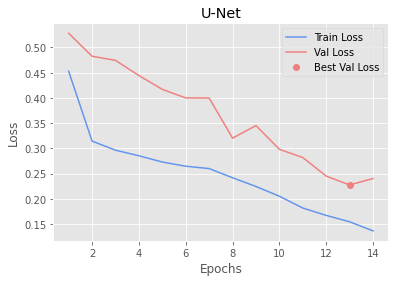


15. epoch



average epoch train loss was: 0.12246863916516304


<Figure size 432x288 with 0 Axes>

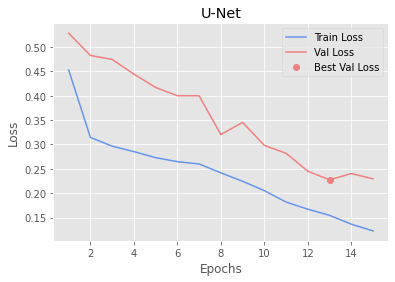


16. epoch



average epoch train loss was: 0.12427261083697279


<Figure size 432x288 with 0 Axes>

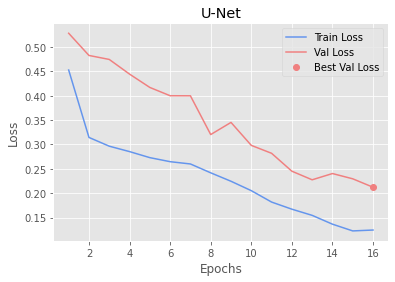

At epoch 16 a new best model was found and saved!

17. epoch



average epoch train loss was: 0.10777193424291909


<Figure size 432x288 with 0 Axes>

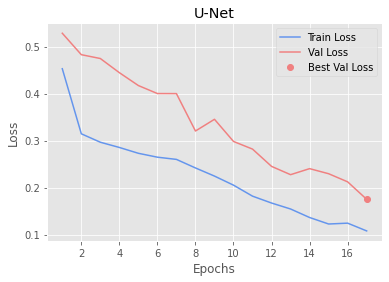

At epoch 17 a new best model was found and saved!

18. epoch



average epoch train loss was: 0.09995577360192935


<Figure size 432x288 with 0 Axes>

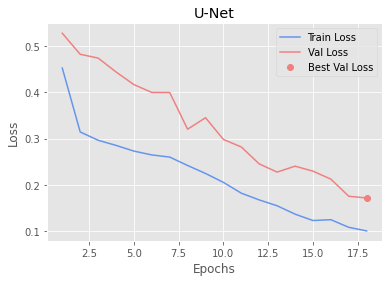

At epoch 18 a new best model was found and saved!

19. epoch



average epoch train loss was: 0.09496876100699107


<Figure size 432x288 with 0 Axes>

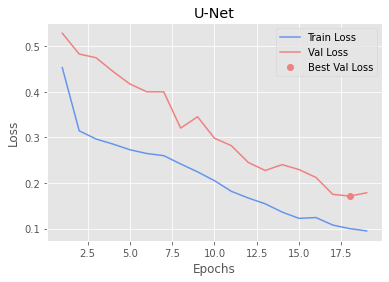


20. epoch



average epoch train loss was: 0.09326697047799826


<Figure size 432x288 with 0 Axes>

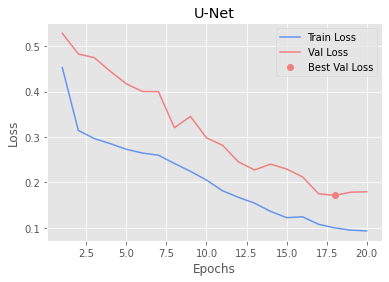


21. epoch



average epoch train loss was: 0.08227880741469562


<Figure size 432x288 with 0 Axes>

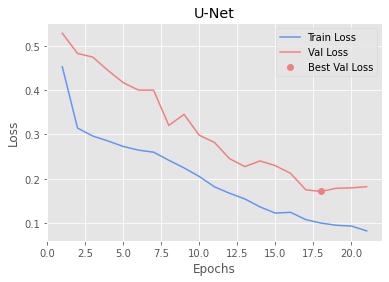


22. epoch



average epoch train loss was: 0.0902240628687044


<Figure size 432x288 with 0 Axes>

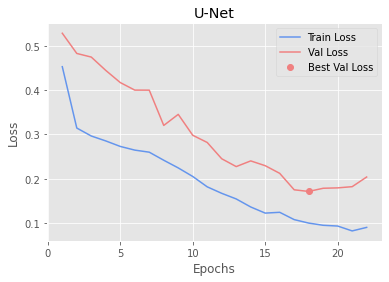


23. epoch



average epoch train loss was: 0.08230698046584924


<Figure size 432x288 with 0 Axes>

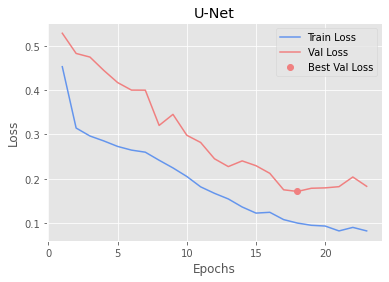


24. epoch



average epoch train loss was: 0.07029565734167893


<Figure size 432x288 with 0 Axes>

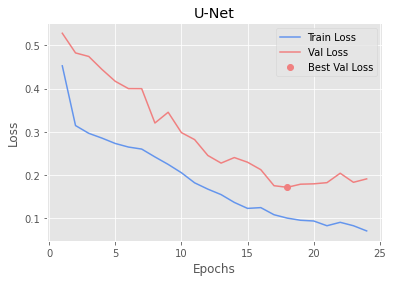


25. epoch



average epoch train loss was: 0.07341680054863294


<Figure size 432x288 with 0 Axes>

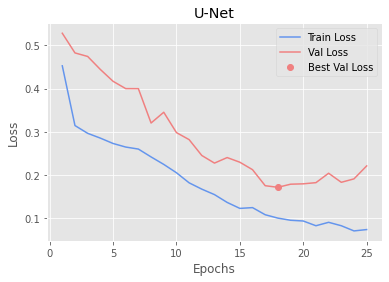


26. epoch



average epoch train loss was: 0.0621255812390397


<Figure size 432x288 with 0 Axes>

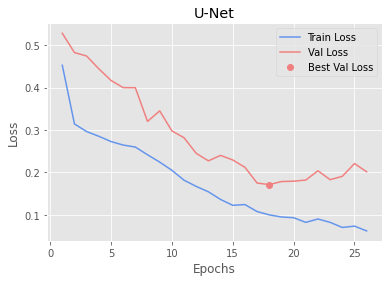


27. epoch



average epoch train loss was: 0.05662987179433306


<Figure size 432x288 with 0 Axes>

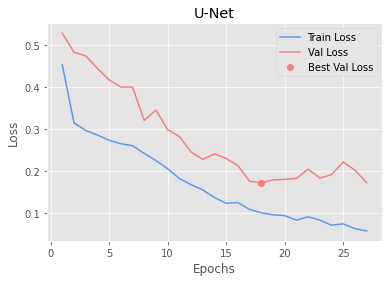


28. epoch



average epoch train loss was: 0.052521088936676584


<Figure size 432x288 with 0 Axes>

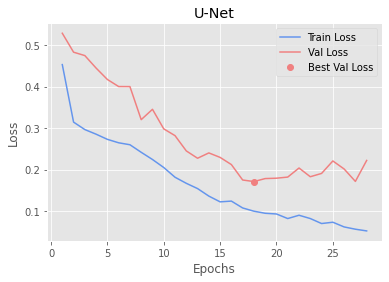


29. epoch



average epoch train loss was: 0.05344315113810202


<Figure size 432x288 with 0 Axes>

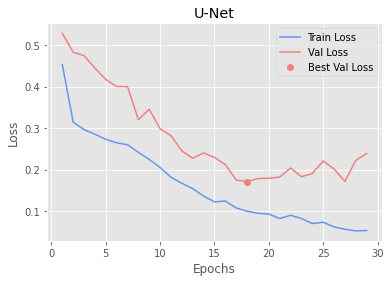


30. epoch



average epoch train loss was: 0.06192998502713939


<Figure size 432x288 with 0 Axes>

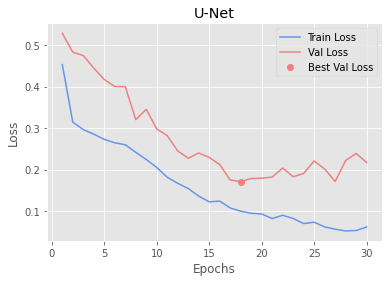

Finished Training


In [11]:
# training loop
batch_size =10 # I HAVE SEEN IT RUN WITH AS MUCH AS batch_size=25
                # IF it wont run due to memory issues restart the runtime
num_epoch = 30

#make a new training or keep training
new_training = True
if new_training:
  print("A new training has started!")
  train_set = Dataset(IDs_train, means_train, stds_train)
  val_set = Dataset(IDs_val, means_val, stds_val)
  test_set = Dataset(IDs_test, means_test,  stds_test)
  test_set2 = Dataset(IDs_test2, means_test2,  stds_test2)
  
  train_params = {'batch_size': batch_size, 'shuffle': True}
  rest_params = {'batch_size': 1, 'shuffle': False}

  training_generator = torch.utils.data.DataLoader(train_set, **train_params)
  val_generator = torch.utils.data.DataLoader(val_set, **rest_params)
  test_generator = torch.utils.data.DataLoader(test_set, **rest_params)
  test2_generator = torch.utils.data.DataLoader(test_set2, **rest_params)

  unet = Net(input_height, input_width, in_channels, 16, kernel_size, out_channels, padding)
  unet.cuda()

  criterion = nn.BCELoss()
  optimizer = optim.Adam(unet.parameters(), lr=0.001)
  #optimizer = optim.SGD(unet.parameters(), lr = 0.001, momentum=0.98)
  epoch_train_loss_list = []
  epoch_val_loss_list = []
  epoch_test_loss_list = []
  epoch_test2_loss_list = []
  best_avg_loss = 1
  epoch_counter = 0
  
else:
  print("Training continued")



for epoch in range(num_epoch):  # loop over the dataset multiple times
    unet.train()  
    epoch_counter += 1 #dont change this, it has to extern and not just depend on the "epoch" loop iterator
    print("\n{}. epoch".format(epoch_counter))

    epoch_loss = 0
    c = 1
    for i, data in tqdm(enumerate(training_generator, 0)):
        # get the inputs
        inputs, labels, idx = data

        # wrap them in Variable
        inputs = Variable(inputs).cuda()
        labels = Variable(labels).type(torch.float32).cuda()

        optimizer.zero_grad()
        output = unet(inputs)
        
        batch_loss = criterion(output.squeeze(), labels.squeeze())
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.detach().item()
        c += 1
        #print('[%d, %5d] batch loss: %.2f' %(epoch + 1, i + 1, batch_loss))
    
    print("average epoch train loss was: {}".format(epoch_loss/c))
    epoch_train_loss_list.append(epoch_loss/c)

    #get the test results after each epoch:
    unet.eval()
    epoch_val_loss_list.append(  get_loss_and_acc(val_generator,   unet, criterion, IDs_test = IDs_val, only_loss = True))
    #epoch_test2_loss_list.append(get_loss_and_acc(test2_generator, unet, criterion, only_loss = True))
    #epoch_test_loss_list.append( get_loss_and_acc(test_generator,  unet, criterion, only_loss = True))

    plt.figure()
    plt.plot(range(1,len(epoch_train_loss_list)+1), epoch_train_loss_list, label = "Train Loss",color = "cornflowerblue")
    plt.plot(range(1,len(epoch_val_loss_list)+1), epoch_val_loss_list, label = "Val Loss",color = "lightcoral")
    plt.plot(epoch_val_loss_list.index(min(epoch_val_loss_list))+1, min(epoch_val_loss_list),"o",color = "lightcoral", label = "Best Val Loss")
    #plt.plot(range(1,len(epoch_test_loss_list)+1), epoch_test_loss_list, label = "Test loss")
    #plt.plot(range(1,len(epoch_test2_loss_list)+1), epoch_test2_loss_list, label = "Test2 loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("U-Net")
    plt.legend()
    plt.savefig('unet.png', dpi=300)
    plt.show()

    #saves the model if its better than the previous best based on test loss
    #epoch_avg_loss = (epoch_test_loss_list[-1]*20 + epoch_test2_loss_list[-1]*60)/(60+20)
    #print(c)
    #print()
    if best_avg_loss > epoch_val_loss_list[-1] and epoch > 10:
      #               loss    count      f1         f1_obj     hausdorff
    #  test_acc = get_loss_and_acc(test_generator, unet, criterion, plot_ = 3)
      #test2_acc = get_loss_and_acc(test2_generator, unet, criterion)

      best_avg_loss = epoch_val_loss_list[-1]
      path = 'drive/My Drive/unet.pt'
      torch.save(unet.state_dict(),path)

      print("At epoch {} a new best model was found and saved!".format(epoch+1))
    #  print("Loss, count, f1, f1_obj, hausdorff")
    #  print("test1: ", test_acc)
      #print("test2: ", test2_acc)

print('Finished Training')

Manual backup plot for the "loss as a funtion of epochs" graph

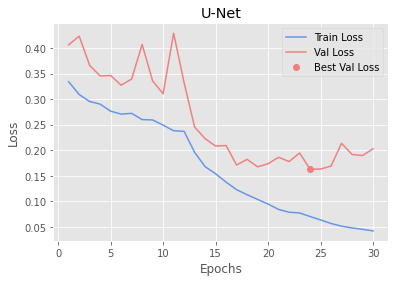

[0.3340392764657736, 0.3090652817239364, 0.2952956312025587, 0.2901732875034213, 0.27638912107795477, 0.2706397982935111, 0.272105660289526, 0.2599102631211281, 0.2592153415704767, 0.24901516580333313, 0.23815772651384273, 0.23686457394311825, 0.19584072070817152, 0.16782668698579073, 0.1538518376958867, 0.1374794812873006, 0.12276537731910746, 0.11280994738141696, 0.1037014676257968, 0.09458783633696537, 0.08403817385745545, 0.07858705210189025, 0.07716055912896991, 0.0702511437702924, 0.06350234523415565, 0.05647508714658519, 0.05127671003962556, 0.04781990645763775, 0.04509988551338514, 0.041983311995863914]
[0.4062908999621868, 0.4232927970588207, 0.36601874604821205, 0.3453280106186867, 0.3461761213839054, 0.3272901251912117, 0.33926165476441383, 0.4071390926837921, 0.33553862757980824, 0.3105929773300886, 0.42893891781568527, 0.332042520865798, 0.24536673724651337, 0.22261641174554825, 0.20813467167317867, 0.2091344092041254, 0.17088733986020088, 0.1821448765695095, 0.16742706997

In [12]:
epoch_train_loss_list = [0.3340392764657736, 0.3090652817239364, 0.2952956312025587, 0.2901732875034213, 0.27638912107795477, 0.2706397982935111, 0.272105660289526, 0.2599102631211281, 0.2592153415704767, 0.24901516580333313, 0.23815772651384273, 0.23686457394311825, 0.19584072070817152, 0.16782668698579073, 0.1538518376958867, 0.1374794812873006, 0.12276537731910746, 0.11280994738141696, 0.1037014676257968, 0.09458783633696537, 0.08403817385745545, 0.07858705210189025, 0.07716055912896991, 0.0702511437702924, 0.06350234523415565, 0.05647508714658519, 0.05127671003962556, 0.04781990645763775, 0.04509988551338514, 0.041983311995863914]
epoch_val_loss_list = [0.4062908999621868, 0.4232927970588207, 0.36601874604821205, 0.3453280106186867, 0.3461761213839054, 0.3272901251912117, 0.33926165476441383, 0.4071390926837921, 0.33553862757980824, 0.3105929773300886, 0.42893891781568527, 0.332042520865798, 0.24536673724651337, 0.22261641174554825, 0.20813467167317867, 0.2091344092041254, 0.17088733986020088, 0.1821448765695095, 0.16742706997320056, 0.17346062324941158, 0.1861533964984119, 0.17774419533088803, 0.19456140603870153, 0.16288962913677096, 0.16303164744749665, 0.16896849684417248, 0.21348888240754604, 0.19159960094839334, 0.1895752688869834, 0.2027008170261979]
    
    
plt.figure()
plt.plot(range(1,len(epoch_train_loss_list)+1), epoch_train_loss_list, label = "Train Loss",color = "cornflowerblue")
plt.plot(range(1,len(epoch_val_loss_list)+1), epoch_val_loss_list, label = "Val Loss",color = "lightcoral")
plt.plot(epoch_val_loss_list.index(min(epoch_val_loss_list))+1, min(epoch_val_loss_list),"o",color = "lightcoral", label = "Best Val Loss")
#plt.plot(range(1,len(epoch_test_loss_list)+1), epoch_test_loss_list, label = "Test loss")
#plt.plot(range(1,len(epoch_test2_loss_list)+1), epoch_test2_loss_list, label = "Test2 loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("U-Net")
plt.legend()
plt.savefig('unet.png', dpi=300)
plt.show()
print(epoch_train_loss_list)
print(epoch_val_loss_list)